# Project 5.3

In [6]:
# -*- coding: utf-8 -*-
"""
Formulas being checked:
(a) ∫0^t 4 B_s^3 dB_s  =  B_t^4 - 6 ∫0^t B_s^2 ds
(b) ∫0^t cos(B_s) dB_s =  sin(B_t) + (1/2) ∫0^t sin(B_s) ds
(c) 1 - ∫0^t e^{s/2} sin(B_s) dB_s = e^{t/2} cos(B_t)
"""

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# ------------------------
# Core simulation helpers
# ------------------------
def brownian_path(T=1.0, dt=0.01, seed=20250919):
    """
    Generate one Brownian motion path on [0,T] with steps dt.
    Returns (t, B, dB, dt).
    """
    rng = np.random.RandomState(seed)
    n = int(T / dt)
    t = np.linspace(0.0, T, n + 1)              # t_0,...,t_n
    dB = np.sqrt(dt) * rng.randn(n)             # increments ΔB_i
    B = np.empty(n + 1)
    B[0] = 0.0
    B[1:] = np.cumsum(dB)
    return t, B, dB, dt

def left_riemann_dt_cum(g_vals, dt):
    """
    Cumulative ∫ g_s ds with left-point rule on the same grid.
    g_vals is g(B_{t_i}) at i=0,...,n-1 (length n).
    Returns array of length n+1 with 0 at index 0.
    """
    out = np.zeros(len(g_vals) + 1)
    out[1:] = np.cumsum(g_vals * dt)
    return out

def ito_cum(g_left, dB):
    """
    Cumulative Itô integral ∫ g(B_s) dB_s with left-point rule:
    sum_{i=0}^{n-1} g(B_{t_i}) * ΔB_i.
    g_left is g(B_{t_i}) for i=0,...,n-1 (length n).
    dB     is ΔB_i (length n).
    Returns array of length n+1 with 0 at index 0.
    """
    out = np.zeros(len(dB) + 1)
    out[1:] = np.cumsum(g_left * dB)
    return out

In [8]:
# ------------------------
# Build the three processes
# ------------------------
def build_processes(T=1.0, dt=0.01, seed=20250919):
    """
    Constructs both sides (Itô integral vs closed-form) for (a)(b)(c)
    on the same Brownian path.
    Returns a dict with time grid and six trajectories.
    """
    t, B, dB, dt = brownian_path(T=T, dt=dt, seed=seed)

    # Precompute left-point function values (length n)
    B_left = B[:-1]                       # B_{t_i}, i=0..n-1
    t_left = t[:-1]                       # t_i, same indexing

    # --- (a) ---
    # Itô side: ∫ 4 B_s^3 dB_s
    g_a_left = 4.0 * (B_left ** 3)
    ito_a = ito_cum(g_a_left, dB)
    # Closed-form side: B_t^4 - 6 ∫ B_s^2 ds
    int_B2_ds = left_riemann_dt_cum(B_left ** 2, dt)
    closed_a = (B ** 4) - 6.0 * int_B2_ds

    # --- (b) ---
    # Itô side: ∫ cos(B_s) dB_s
    g_b_left = np.cos(B_left)
    ito_b = ito_cum(g_b_left, dB)
    # Closed-form side: sin(B_t) + 0.5 ∫ sin(B_s) ds
    int_sinB_ds = left_riemann_dt_cum(np.sin(B_left), dt)
    closed_b = np.sin(B) + 0.5 * int_sinB_ds

    # --- (c) ---
    # Itô side: 1 - ∫ e^{s/2} sin(B_s) dB_s
    g_c_left = np.exp(t_left / 2.0) * np.sin(B_left)
    ito_c = 1.0 - ito_cum(g_c_left, dB)
    # Closed-form side: e^{t/2} cos(B_t)
    closed_c = np.exp(t / 2.0) * np.cos(B)

    return {
        "t": t,
        "B": B,
        # (a)
        "ito_a": ito_a,
        "closed_a": closed_a,
        # (b)
        "ito_b": ito_b,
        "closed_b": closed_b,
        # (c)
        "ito_c": ito_c,
        "closed_c": closed_c,
    }

In [9]:
# ------------------------
# plotting
# ------------------------
def plot_compare(t, lhs, rhs, title):
    """
    Plot two trajectories to visually compare Itô integral (lhs)
    vs closed-form (rhs). Expect near overlap on the same path.
    """
    plt.figure(figsize=(7, 4))
    plt.plot(t, lhs, label="Itô integral (left-point)", linewidth=1.8)
    plt.plot(t, rhs, label="Closed-form (Itô formula)", linestyle="--")
    plt.title(title)
    plt.xlabel("t")
    plt.legend()
    plt.tight_layout()

def plot_all(res):
    plot_compare(res["t"], res["ito_a"], res["closed_a"], "(a) 4B^3 ∘ dB  vs  B^4 - 6∫B^2 ds")
    plot_compare(res["t"], res["ito_b"], res["closed_b"], "(b) cos(B) ∘ dB   vs  sin(B) + 0.5∫sin(B) ds")
    plot_compare(res["t"], res["ito_c"], res["closed_c"], "(c) 1 - ∫e^{s/2}sin(B) dB  vs  e^{t/2}cos(B)")

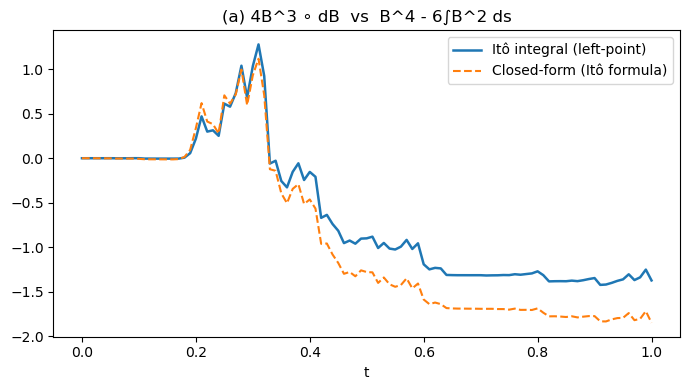

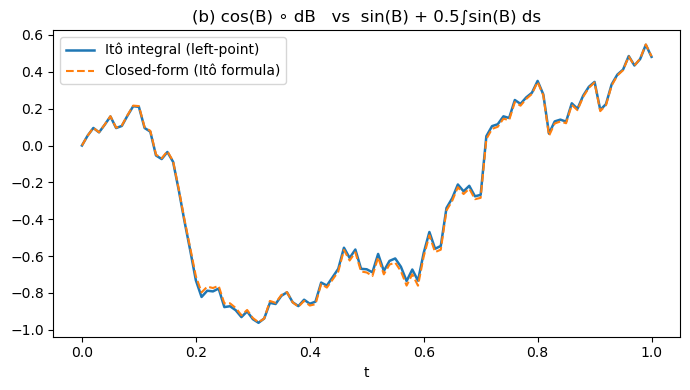

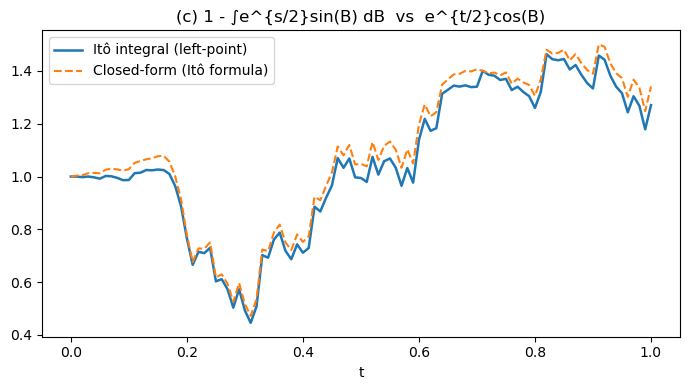

In [10]:
res = build_processes(T=1.0, dt=0.01, seed=20250919)
plot_all(res); plt.show()

# Project 5.4

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_paths_T1_dt001(n_paths=10, seed=42):
    """
    Numerical Project 5.4: Path-dependent integrand
    Xt = ∫_0^t B_s dB_s,  It = ∫_0^t X_s dB_s  on [0,1] with dt=0.01.

    Discretization (Itô left Riemann sums):
        ΔB_j ~ N(0, dt)
        X_{j} = X_{j-1} + B_{j-1} * ΔB_j
        I_{j} = I_{j-1} + X_{j-1} * ΔB_j
    """
    T = 1.0
    dt = 0.01
    n_steps = int(T / dt)
    t = np.linspace(0.0, T, n_steps + 1)

    rng = np.random.default_rng(seed)

    # 1) Brownian motion paths
    dB = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(n_steps, n_paths))
    B = np.zeros((n_steps + 1, n_paths))
    B[1:] = np.cumsum(dB, axis=0)

    # 2) Recursively build X and I using Itô left-point scheme
    X = np.zeros_like(B)
    I = np.zeros_like(B)

    # vectorized recursion over time
    for j in range(1, n_steps + 1):
        dB_j = dB[j - 1]            # shape: (n_paths,)
        X[j] = X[j - 1] + B[j - 1] * dB_j
        I[j] = I[j - 1] + X[j - 1] * dB_j

    return t, B, X, I

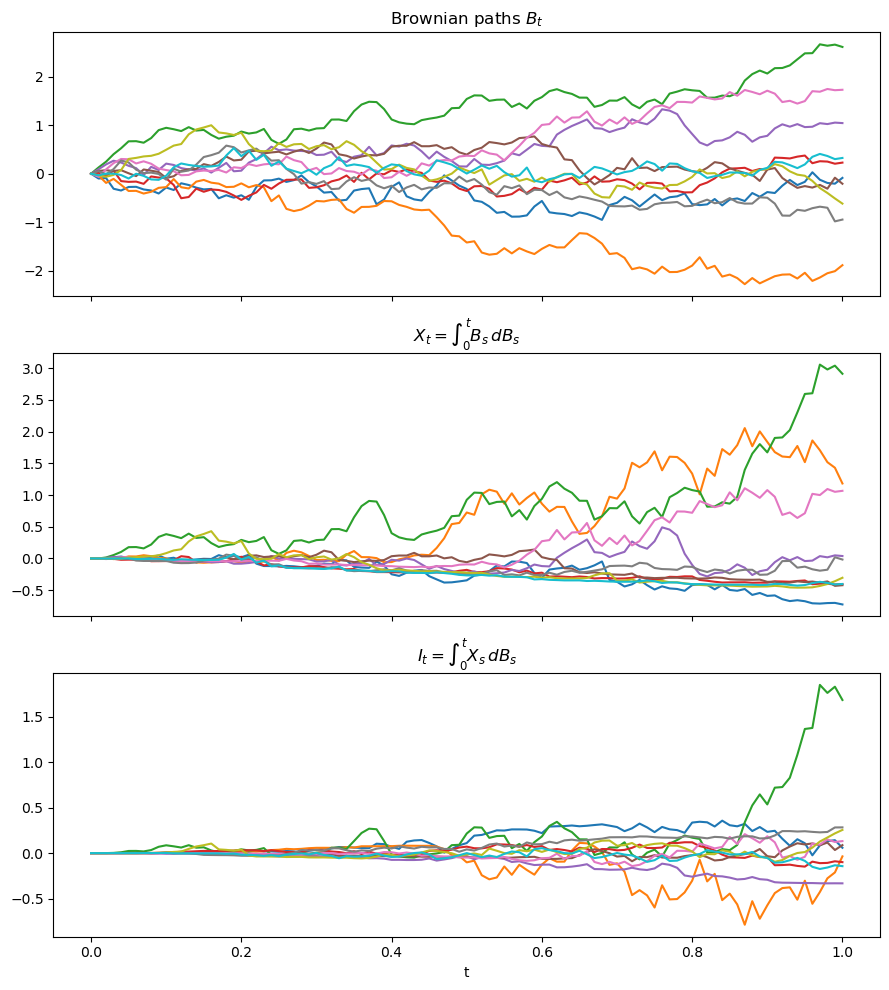

In [12]:
t, B, X, I = simulate_paths_T1_dt001(n_paths=10, seed=123)

fig, axs = plt.subplots(3, 1, figsize=(9, 10), sharex=True)
axs[0].plot(t, B[:, :10]); axs[0].set_title("Brownian paths $B_t$")
axs[1].plot(t, X[:, :10]); axs[1].set_title(r"$X_t=\int_0^t B_s\,dB_s$")
axs[2].plot(t, I[:, :10]); axs[2].set_title(r"$I_t=\int_0^t X_s\,dB_s$")
axs[2].set_xlabel("t")
plt.tight_layout()
plt.show()